In [ ]:
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# from public_tests_a1 import *

tf.keras.backend.set_floatx('float64')
# from assigment_utils import *

tf.autograph.set_verbosity(0)

In [ ]:
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.widgets import Button, CheckButtons
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

from ipywidgets import Output
np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
plt.style.use('/content/deeplearning.mplstyle')

# --- Assignment ----------------------------------------
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)

class lin_model:
    def __init__(self, degree, regularization = False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()

    def fit(self, X_train,y_train):
        ''' just fits the data. mapping and scaling are not repeated '''
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train )

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)

    def mse(self, y, yhat):
        err = mean_squared_error(y,yhat)/2   #sklean doesn't have div by 2
        return (err)

def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.set_title("Poor Performance on Test Data",fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(X_train, y_train, color = "red",           label="train")
    ax.scatter(X_test, y_test,       color = dlc["dlblue"], label="test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred,  lw=0.5, label=f"predicted, degree={degree}")
    ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = dlc["dlblue"])
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = dlc["dlorange"])
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = dlc["dlmagenta"])
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3",
                                   color=dlc['dldarkred'], lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)
    err_cv = np.zeros(num_steps)
    y_pred = np.zeros((100,num_steps))

    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = dlc["dlblue"])

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend()
    plt.tight_layout()
    plt.show()

dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')


#Plot a multi-class categorical decision boundary
# This version handles a non-vector prediction (adds a for-loop over points)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw)
    ax.axis('tight')

def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()


def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    #plot the decison boundary.
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("training data", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes,
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()


def eval_cat_err(y, yhat):
    """
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      err: (scalar)
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:
            incorrect += 1
    err = incorrect/m
    return(err)

def plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv):
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        err_train[i] = eval_cat_err(y_train,np.argmax( models[i](X_train), axis=1))
        err_cv[i] = eval_cat_err(y_cv, np.argmax( models[i](X_cv), axis=1))

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("error vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train error", color = dlc["dlblue"])
    ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = dlc["dlorange"])
    ax.set_xscale('log')
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Error",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    ax.text(0.05,0.14,"Training Error\nlower than CV",fontsize=12, ha='left',transform=ax.transAxes,color = dlc["dlblue"])
    ax.text(0.95,0.14,"Similar\nTraining, CV",    fontsize=12, ha='right',transform=ax.transAxes,color = dlc["dlblue"])
    plt.show()

# not used but will calculate the erro assuming an equal distance
def err_all_equal(X_train,X_cv,X_test, y_train,y_cv,y_test, centers):
    X_all = np.concatenate((X_train,X_cv,X_test), axis=0)
    y_all = np.concatenate((y_train,y_cv,y_test), axis=0)
    m = len(X_all)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X_all[i], centers)
    err_all = eval_cat_err(y_all, y_eq)
    return(err_all)

def plt_compare(X,y, classes, simple, regularized, centers):
    plt.close("all")
    fig,ax = plt.subplots(1,3, figsize=(8,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

  #plt simple
    plot_cat_decision_boundary(ax[0], X, simple,  vector=True)
    ax[0].set_title("Simple Model", fontsize=14)
    plt_mc_data(ax[0], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt regularized
    plot_cat_decision_boundary(ax[1], X, regularized,  vector=True)
    ax[1].set_title("Regularized Model", fontsize=14)
    plt_mc_data(ax[1], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[1].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt ideal
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[2], X, cat_predict,  vector=False)
    ax[2].set_title("Ideal Model", fontsize=14)
    plt_mc_data(ax[2], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[2].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    err_s = eval_cat_err(y, simple(X))
    err_r = eval_cat_err(y, regularized(X))
    ax[0].text(-2.75,3,f"err_test={err_s:0.2f}", fontsize=12)
    ax[1].text(-2.75,3,f"err_test={err_r:0.2f}", fontsize=12)
    m = len(X)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X[i], centers)
    err_eq = eval_cat_err(y, y_eq)
    ax[2].text(-2.75,3,f"err_test={err_eq:0.2f}", fontsize=12)
    plt.show()

# --- End Assignm




# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


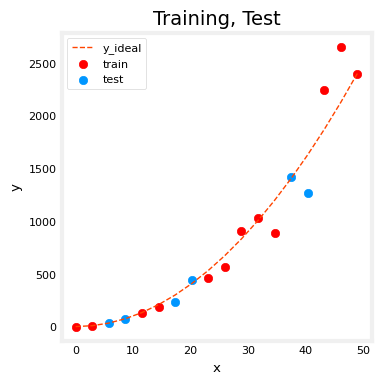

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [ ]:
def eval_mse(yhat,y):
  """This funcions finds the mse for the data"""

  # so first of all here we just loop through the values of yhat and calculate it

  m = y.shape[0]
  total_loss=0
  for i in range(m):
    err = yhat[i]-y[i]
    error_squared = err**2
    total_loss+=error_squared

  return (total_loss/(2*m))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import numpy as np

def test_eval_mse(target):
    y_hat = np.array([2.4, 4.2])
    y_tmp = np.array([2.3, 4.1])
    result = target(y_hat, y_tmp)

    assert np.isclose(result, 0.005, atol=1e-6), f"Wrong value. Expected 0.005, got {result}"

    y_hat = np.array([3.] * 10)
    y_tmp = np.array([3.] * 10)
    result = target(y_hat, y_tmp)
    assert np.isclose(result, 0.), f"Wrong value. Expected 0.0 when y_hat == t_tmp, but got {result}"

    y_hat = np.array([3.])
    y_tmp = np.array([0.])
    result = target(y_hat, y_tmp)
    assert np.isclose(result, 4.5), f"Wrong value. Expected 4.5, but got {result}. Remember the square termn"

    y_hat = np.array([3.] * 5)
    y_tmp = np.array([2.] * 5)
    result = target(y_hat, y_tmp)
    assert np.isclose(result, 0.5), f"Wrong value. Expected 0.5, but got {result}. Remember to divide by (2*m)"

    print("\033[92m All tests passed.")

def test_eval_cat_err(target):
    y_hat = np.array([1, 0, 1, 1, 1, 0])
    y_tmp = np.array([0, 1, 0, 0, 0, 1])
    result = target(y_hat, y_tmp)
    assert not np.isclose(result, 6.), f"Wrong value. Expected 1, but got {result}. Did you divided by m?"

    y_hat = np.array([1, 2, 0])
    y_tmp = np.array([1, 2, 3])
    result = target(y_hat, y_tmp)
    assert np.isclose(result, 1./3., atol=1e-6), f"Wrong value. Expected 0.333, but got {result}"

    y_hat = np.array([1, 0, 1, 1, 1, 0])
    y_tmp = np.array([1, 1, 1, 0, 0, 0])
    result = target(y_hat, y_tmp)
    assert np.isclose(result, 3./6., atol=1e-6), f"Wrong value. Expected 0.5, but got {result}"

    y_hat = np.array([[1], [2], [0], [3]])
    y_tmp = np.array([[1], [2], [1], [3]])
    res_tmp =  target(y_hat, y_tmp)
    assert type(res_tmp) != np.ndarray, f"The output must be an scalar but got {type(res_tmp)}"

    print("\033[92m All tests passed.")

def model_test(target, classes, input_size):
    target.build(input_shape=(None,input_size))
    expected_lr = 0.01

    assert len(target.layers) == 3, \
        f"Wrong number of layers. Expected 3 but got {len(target.layers)}"
    assert target.input.shape.as_list() == [None, input_size], \
        f"Wrong input shape. Expected [None,  {input_size}] but got {target.input.shape.as_list()}"
    i = 0
    expected = [[Dense, [None, 120], relu],
                [Dense, [None, 40], relu],
                [Dense, [None, classes], linear]]

    for layer in target.layers:
        assert type(layer) == expected[i][0], \
            f"Wrong type in layer {i}. Expected {expected[i][0]} but got {type(layer)}"
        assert layer.output.shape.as_list() == expected[i][1], \
            f"Wrong number of units in layer {i}. Expected {expected[i][1]} but got {layer.output.shape.as_list()}"
        assert layer.activation == expected[i][2], \
            f"Wrong activation in layer {i}. Expected {expected[i][2]} but got {layer.activation}"
        assert layer.kernel_regularizer == None, "You must not specify any regularizer for any layer"
        i = i + 1

    assert type(target.loss)==SparseCategoricalCrossentropy, f"Wrong loss function. Expected {SparseCategoricalCrossentropy}, but got {target.loss}"
    assert type(target.optimizer)==Adam, f"Wrong loss function. Expected {Adam}, but got {target.optimizer}"
    lr = target.optimizer.learning_rate.numpy()
    assert np.isclose(lr, expected_lr, atol=1e-8), f"Wrong learning rate. Expected {expected_lr}, but got {lr}"
    assert target.loss.get_config()['from_logits'], f"Set from_logits=True in loss function"

    print("\033[92mAll tests passed!")

def model_s_test(target, classes, input_size):
    target.build(input_shape=(None,input_size))
    expected_lr = 0.01

    assert len(target.layers) == 2, \
        f"Wrong number of layers. Expected 3 but got {len(target.layers)}"
    assert target.input.shape.as_list() == [None, input_size], \
        f"Wrong input shape. Expected [None,  {input_size}] but got {target.input.shape.as_list()}"
    i = 0
    expected = [[Dense, [None, 6], relu],
                [Dense, [None, classes], linear]]

    for layer in target.layers:
        assert type(layer) == expected[i][0], \
            f"Wrong type in layer {i}. Expected {expected[i][0]} but got {type(layer)}"
        assert layer.output.shape.as_list() == expected[i][1], \
            f"Wrong number of units in layer {i}. Expected {expected[i][1]} but got {layer.output.shape.as_list()}"
        assert layer.activation == expected[i][2], \
            f"Wrong activation in layer {i}. Expected {expected[i][2]} but got {layer.activation}"
        assert layer.kernel_regularizer == None, "You must not specify any regularizer any layer"
        i = i + 1

    assert type(target.loss)==SparseCategoricalCrossentropy, f"Wrong loss function. Expected {SparseCategoricalCrossentropy}, but got {target.loss}"
    assert type(target.optimizer)==Adam, f"Wrong loss function. Expected {Adam}, but got {target.optimizer}"
    lr = target.optimizer.learning_rate.numpy()
    assert np.isclose(lr, expected_lr, atol=1e-8), f"Wrong learning rate. Expected {expected_lr}, but got {lr}"
    assert target.loss.get_config()['from_logits'], f"Set from_logits=True in loss function"

    print("\033[92mAll tests passed!")

def model_r_test(target, classes, input_size):
    target.build(input_shape=(None,input_size))
    expected_lr = 0.01
    print("ddd")
    assert len(target.layers) == 3, \
        f"Wrong number of layers. Expected 3 but got {len(target.layers)}"
    assert target.input.shape.as_list() == [None, input_size], \
        f"Wrong input shape. Expected [None,  {input_size}] but got {target.input.shape.as_list()}"
    i = 0
    expected = [[Dense, [None, 120], relu, (tf.keras.regularizers.l2, 0.1)],
                [Dense, [None, 40], relu, (tf.keras.regularizers.l2, 0.1)],
                [Dense, [None, classes], linear, None]]

    for layer in target.layers:
        assert type(layer) == expected[i][0], \
            f"Wrong type in layer {i}. Expected {expected[i][0]} but got {type(layer)}"
        assert layer.output.shape.as_list() == expected[i][1], \
            f"Wrong number of units in layer {i}. Expected {expected[i][1]} but got {layer.output.shape.as_list()}"
        assert layer.activation == expected[i][2], \
            f"Wrong activation in layer {i}. Expected {expected[i][2]} but got {layer.activation}"
        if not (expected[i][3] == None):
            assert type(layer.kernel_regularizer) == expected[i][3][0], f"Wrong regularizer. Expected L2 regularizer but got {type(layer.kernel_regularizer)}"
            assert np.isclose(layer.kernel_regularizer.l2,  expected[i][3][1]), f"Wrong regularization factor. Expected {expected[i][3][1]}, but got {layer.kernel_regularizer.l2}"
        else:
            assert layer.kernel_regularizer == None, "You must not specify any regularizer for the 3th layer"
        i = i + 1

    assert type(target.loss)==SparseCategoricalCrossentropy, f"Wrong loss function. Expected {SparseCategoricalCrossentropy}, but got {target.loss}"
    assert type(target.optimizer)==Adam, f"Wrong loss function. Expected {Adam}, but got {target.optimizer}"
    lr = target.optimizer.learning_rate.numpy()
    assert np.isclose(lr, expected_lr, atol=1e-8), f"Wrong learning rate. Expected {expected_lr}, but got {lr}"
    assert target.loss.get_config()['from_logits'], f"Set from_logits=True in loss function"

    print("\033[92mAll tests passed!")


y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)
#

 All tests passed.


In [ ]:
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train,y_train)

yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [ ]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


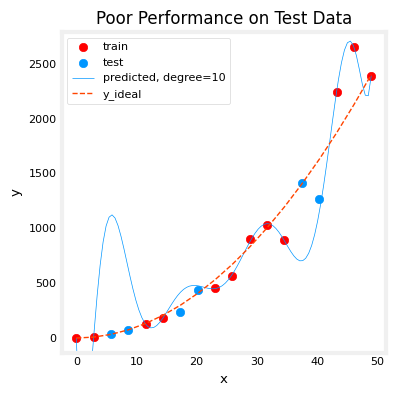

In [ ]:
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

In [ ]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


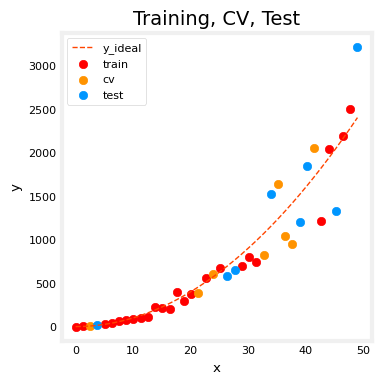

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [ ]:
# we write the max_degree uptil which we want to calculate the data
# then in that range we use the algo of the model to calculate the error mostly done using sklearns algo.mse
# keep storing those degrees and the err in  the training and the cv lists




max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0,int(X.max()),100)
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv)+1
optimal_degree

2

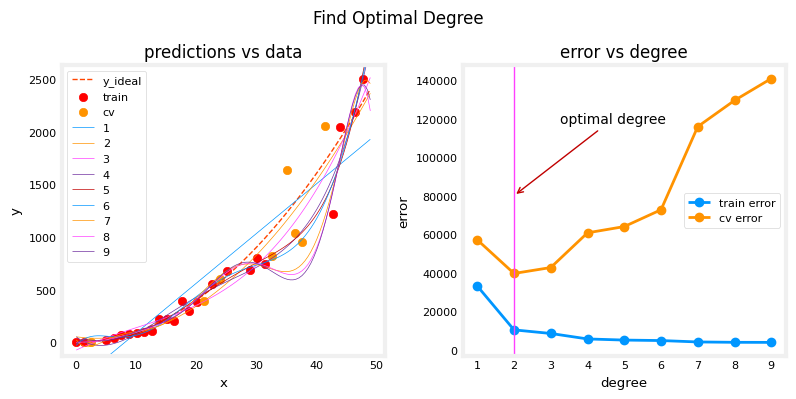

In [ ]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal,
                   err_train, err_cv, optimal_degree, max_degree)

In [ ]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0,int(X.max()),100)
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

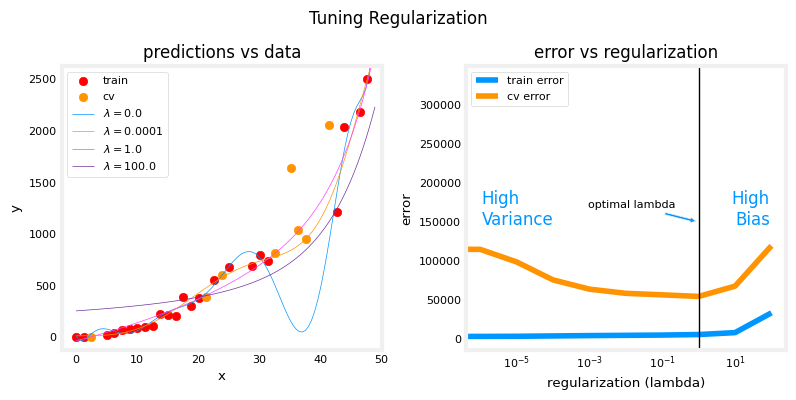

In [ ]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

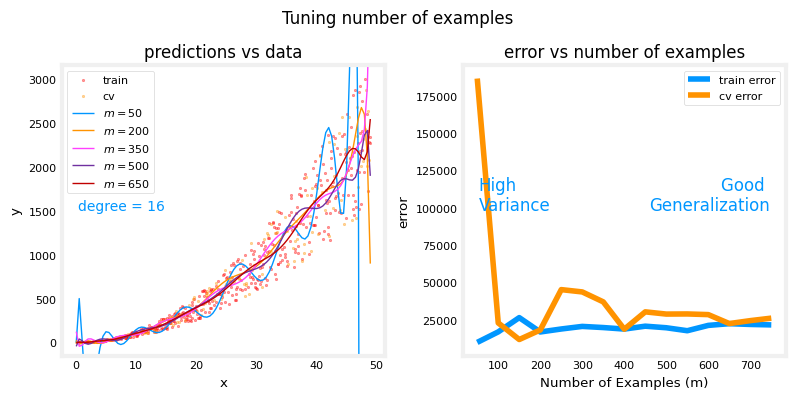

In [ ]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

In [ ]:
tune_m()

(array([34.08,  6.48, 35.92, 40.5 , 15.44, 23.81, 32.32, 34.35, 21.92,
        25.64, 31.4 , 12.17, 32.97, 44.42, 17.01, 33.89, 10.01, 33.76,
        19.89, 13.08, 48.8 ,  5.1 , 20.41, 44.36, 42.26,  2.75,  8.7 ,
        30.94, 39.97, 16.36, 34.67, 31.53, 22.31, 12.56, 14.39, 26.69,
        46.19, 47.69, 29.18, 33.36, 10.27, 35.2 , 17.79, 47.17, 25.97,
        20.02, 43.11,  6.67,  3.4 , 10.21, 31.86, 26.1 ,  6.35, 28.98,
         8.37, 11.58, 22.7 ,  7.2 , 36.64, 33.3 , 24.47, 22.44, 42.33,
         9.29, 39.51,  0.39, 17.47, 38.07, 15.5 , 40.1 ,  3.79, 15.18,
        44.94, 44.81, 13.28, 34.74, 18.58, 32.12,  0.13, 48.08, 29.31,
        14.2 , 23.55,  3.01, 47.1 , 14.72,  1.18, 10.99, 14.92, 19.1 ,
        24.66, 14.85, 41.08, 36.96, 21.46, 18.51, 45.6 , 37.81, 46.06,
        32.78,  6.08, 13.93, 16.88, 22.05, 19.04, 46.58,  6.93,  7.52,
        10.34, 48.67, 45.4 ,  2.36,  6.87, 25.84, 23.68, 35.39, 13.35,
        15.96, 14.46, 16.09, 23.88, 33.82, 36.5 , 47.23, 35.72, 22.96,
      

In [ ]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


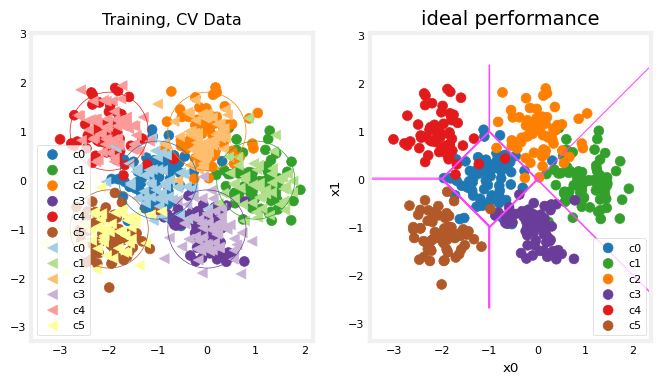

In [ ]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

In [ ]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ###
        if(yhat[i]!=y[i]):
            incorrect+=1
    ### END CODE HERE ###
    cerr=incorrect/m
    return(cerr)
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


In [ ]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ###
    ], name="Complex"
)
model.compile(
    ### START CODE HERE ###
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### END CODE HERE ###
)
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 4ms/step - loss: 1.7093
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.4906
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.2827
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0673
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8738
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7065
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5893
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5052
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4503
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4099
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3798
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3585
Epoch 13/1000
13/13 [====

In [ ]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ###
    ], name="Complex"
)
model.compile(
    ### START CODE HERE ###
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### END CODE HERE ###
)
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 2s 6ms/step - loss: 1.7348
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 1.4973
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 1.2967
Epoch 4/1000
13/13 [==============================] - 0s 9ms/step - loss: 1.0850
Epoch 5/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.8927
Epoch 6/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.7358
Epoch 7/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.6256
Epoch 8/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.5383
Epoch 9/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4779
Epoch 10/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4356
Epoch 11/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4021
Epoch 12/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3796
Epoch 13/1000
13/13 [===

In [ ]:
model.summary()

model_test(model, classes, X_train.shape[1])

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 120)               360       
                                                                 
 dense_7 (Dense)             (None, 40)                4840      
                                                                 
 dense_8 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


AssertionError: Wrong learning rate. Expected 0.01, but got 0.001

1082/1082 [==============================] - 5s 4ms/step


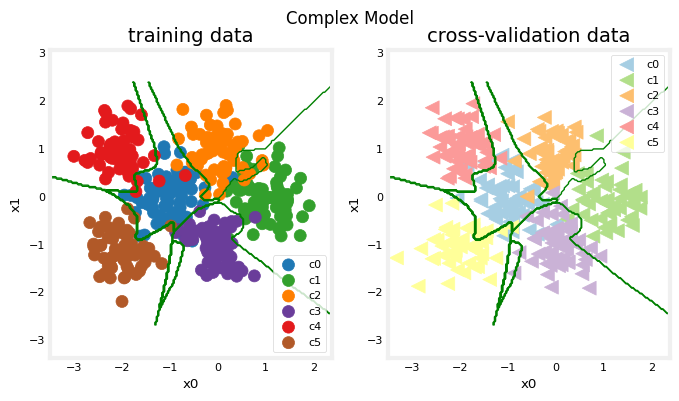

In [ ]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [ ]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 3ms/step
categorization error, training, complex model: 0.035
categorization error, cv,       complex model: 0.087


In [ ]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ###
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ###
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### START CODE HERE ###
)

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 2s 4ms/step - loss: 1.7889
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.7563
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.7267
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.6973
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6703
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.6424
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6166
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5915
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5660
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5405
Epoch 11/1000
13/13 [==============================] - 0s 6ms/step - loss: 1.5157
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.4906
Epoch 13/1000
13/13 [====

In [ ]:
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6)                 18        
                                                                 
 dense_10 (Dense)            (None, 6)                 42        
                                                                 
Total params: 60 (480.00 Byte)
Trainable params: 60 (480.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


AssertionError: Wrong learning rate. Expected 0.01, but got 0.001

1082/1082 [==============================] - 1s 1ms/step


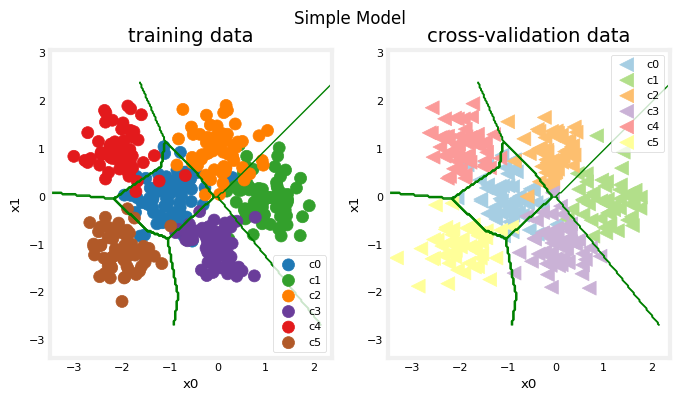

In [ ]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [ ]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 7ms/step
categorization error, training, simple model, 0.062, complex model: 0.035
categorization error, cv,       simple model, 0.056, complex model: 0.087


In [ ]:

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation="linear")
        ### START CODE HERE ###
    ], name= None
)
model_r.compile(
    ### START CODE HERE ###
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    ### START CODE HERE ###
)

In [ ]:
model_r.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 2s 9ms/step - loss: 7.7160
Epoch 2/1000
13/13 [==============================] - 0s 8ms/step - loss: 6.5465
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 5.5717
Epoch 4/1000
13/13 [==============================] - 0s 6ms/step - loss: 4.7595
Epoch 5/1000
13/13 [==============================] - 0s 7ms/step - loss: 4.0926
Epoch 6/1000
13/13 [==============================] - 0s 8ms/step - loss: 3.5409
Epoch 7/1000
13/13 [==============================] - 0s 11ms/step - loss: 3.0944
Epoch 8/1000
13/13 [==============================] - 0s 6ms/step - loss: 2.7260
Epoch 9/1000
13/13 [==============================] - 0s 6ms/step - loss: 2.4227
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 2.1731
Epoch 11/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.9695
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.8017
Epoch 13/1000
13/13 [===

In [ ]:
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 120)               360       
                                                                 
 dense_12 (Dense)            (None, 40)                4840      
                                                                 
 dense_13 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
ddd


AssertionError: Wrong learning rate. Expected 0.01, but got 0.001

1082/1082 [==============================] - 4s 3ms/step


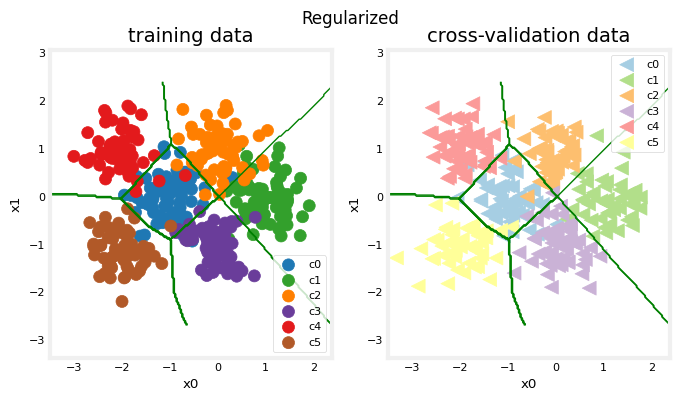

In [ ]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)

plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [ ]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 4ms/step
categorization error, training, regularized: 0.068, simple model, 0.062, complex model: 0.035
categorization error, cv,       regularized: 0.066, simple model, 0.056, complex model: 0.087


In [ ]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")

Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 0s 3ms/step - loss: 0.3613
Epoch 503/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3846
Epoch 504/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3692
Epoch 505/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3576
Epoch 506/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3690
Epoch 507/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3511
Epoch 508/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3361
Epoch 509/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3459
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3416
Epoch 511/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3471
Epoch 512/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3588
Epoch 513/1000
13/13 [=============================

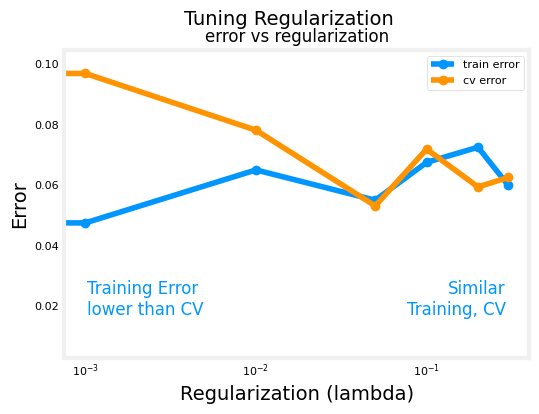

In [ ]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

3/3 [==============================] - 0s 4ms/step


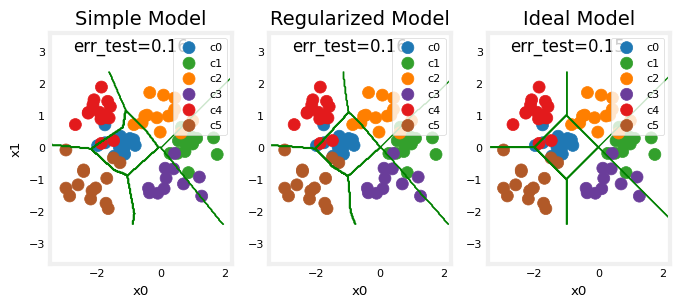

In [ ]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)